In [4]:
#import package
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pylab as plt
import time

from keras.models import Sequential, Model
from keras.layers import Input, RepeatVector
from keras.layers.core import Dense, Dropout, Activation 
from keras.layers.recurrent import LSTM, GRU
from keras import optimizers

%matplotlib inline

print('Done')

Using TensorFlow backend.


Done


In [5]:
def readData():
    data = pd.read_csv('C:/Users/yoon/Python/Stock_Prediction/data/Samsung_20_DIV.csv', parse_dates = [0])
    raw_dates = data.loc[30:, 'date'].reset_index(drop=True)
    del data['date']
    raw_data = data.loc[30:].reset_index(drop=True)
    return raw_data, raw_dates

def split_into_chunks(data, train, predict, step):
    train_set, label_set = [], []
        
    for i in range(0, len(data), step):
        try:  
            temp_train = data.loc[i:i+train-1, 'SMA':'CCI']#.as_matrix()
            temp_train = preprocessing.scale(temp_train)
            temp_label = data.loc[i+train-1+predict, 'return']
            if temp_label > 0:
                temp_label = 1.0
            else:
                temp_label = 0.0
        except:
            break
        train_set.append(temp_train)
        label_set.append(temp_label)
    
    return train_set, label_set

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

def create_Xt_Yt(X, y, percentage=0.8):
#    X, y = shuffle_in_unison(X, y)
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
#    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]
    return X_train, X_test, Y_train, Y_test

print('Done')

Done


In [6]:
timeSeriesList, dates = readData()
TIMESTEPS = 30
TARGET_TIME = 1
STEP_SIZE = 1
EMB_SIZE = 10

print('Done')

Done


In [7]:
X, Y = split_into_chunks(timeSeriesList, TIMESTEPS, TARGET_TIME, STEP_SIZE)
X, Y = np.array(X), np.array(Y)
#X = X.reshape(-1, DATA_SIZE_ON_TRAIN * 10)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
print('Done')

Done


In [34]:
model = Sequential()

inputLayer = Input(shape=(TIMESTEPS, EMB_SIZE))
encoded = LSTM(8, return_sequences=False)(inputLayer)
encoded = RepeatVector(TIMESTEPS)(encoded)

encoded = LSTM(7, return_sequences=False)(encoded)
encoded = RepeatVector(TIMESTEPS)(encoded)

encoded = LSTM(6, return_sequences=False)(encoded)

decoded = RepeatVector(TIMESTEPS)(encoded)
decoded = LSTM(7, return_sequences=False)(decoded)

decoded = RepeatVector(TIMESTEPS)(decoded)
decoded = LSTM(8, return_sequences=False)(decoded)

decoded = RepeatVector(TIMESTEPS)(decoded)
OutputLayer = LSTM(1, return_sequences=False)(decoded)

autoencoder = Model(inputLayer, OutputLayer)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print('Done')

Done


In [8]:
#model = Sequential()

inputLayer = Input(shape=(TIMESTEPS, EMB_SIZE))
encoded = LSTM(8, return_sequences=False)(inputLayer)
decoded = RepeatVector(TIMESTEPS)(encoded)

encoded = LSTM(10, return_sequences=False)(decoded)
decoded = RepeatVector(TIMESTEPS)(encoded)

encoded = LSTM(4, return_sequences=False)(decoded)
decoded = RepeatVector(TIMESTEPS)(encoded)

encoded = LSTM(10, return_sequences=False)(decoded)
decoded = RepeatVector(TIMESTEPS)(encoded)

OutputLayer = LSTM(1, return_sequences=False)(decoded)

autoencoder = Model(inputLayer, OutputLayer)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print('Done')

Done


In [9]:
print("Training...")
autoencoder.fit(X_train, 
            Y_train, 
            epochs = 10,
            batch_size = 128,
            verbose=1)

print("Evaluating...")
score = autoencoder.evaluate(X_test, Y_test, batch_size=128)
print("\nTest loss and accuracy:" + str(score))
print('Done')

Training...
Epoch 1/10
4126/4126 [==============================] - 36s - loss: 0.3511 - acc: 0.5402    
Epoch 2/10
4126/4126 [==============================] - 13s - loss: 0.2482 - acc: 0.5279    
Epoch 3/10
4126/4126 [==============================] - 13s - loss: 0.2478 - acc: 0.5385    
Epoch 4/10
4126/4126 [==============================] - 13s - loss: 0.2475 - acc: 0.5434    
Epoch 5/10
4126/4126 [==============================] - 15s - loss: 0.2472 - acc: 0.5400    
Epoch 6/10
4126/4126 [==============================] - 14s - loss: 0.2472 - acc: 0.5371    
Epoch 7/10
4126/4126 [==============================] - 13s - loss: 0.2467 - acc: 0.5431    
Epoch 8/10
4126/4126 [==============================] - 13s - loss: 0.2465 - acc: 0.5407    
Epoch 9/10
4126/4126 [==============================] - 13s - loss: 0.2461 - acc: 0.5446    
Epoch 10/10
4126/4126 [==============================] - 14s - loss: 0.2460 - acc: 0.5499    
Evaluating...
1032/1032 [==============================] 

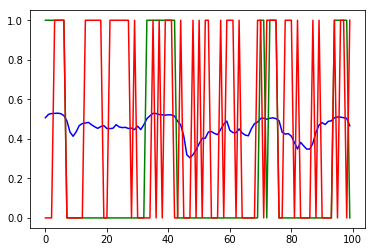

In [10]:
predicted = decoder.predict([X_test1, X_test2])
plt.figure(figsize=(20, 6))
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.plot(range(0,100), predicted[:100], color='blue')
plt.scatter(range(0,100),predicted[:100].round(), color='red', marker='x')
plt.scatter(range(0,100), Y_test[:100], color='black', marker='.')